In [1]:
train_dataset_dir = '/home/Karen/midsize_data'
val_dataset_dir = '/home/Karen/tiny_data'
exp_name = 'mid_experiment'
num_classes = 5

In [2]:
# -*- coding: utf-8 -*- 

from __future__ import print_function, division

import pickle
import sys
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline


from PIL import Image
import time
import copy
import shutil

## first, get the Images (path) and their labels (five personality traits)

In [3]:
def _get_imgname_and_moviename_and_labels(dataset_dir):
    """Returns a list of 
filenames and inferred class names.
    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.
    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
   
    print("processing dataset: "+ dataset_dir)
    img_names = [] 
    movies= []
    labels = []

    annotaion_filename = dataset_dir + "/annotation_training.pkl"
    
    with open(annotaion_filename, 'rb') as f:
        label_dicts = pickle.load(f, encoding='latin1') 

    for movie in os.listdir(dataset_dir):
        if '_5fps' not in movie: continue #skip non-movie files
        raw_moviename = movie.replace('_5fps','.mp4')
        big_five = [label_dicts['extraversion'][raw_moviename], 
                    label_dicts['neuroticism'][raw_moviename],
                    label_dicts['agreeableness'][raw_moviename],
                    label_dicts['conscientiousness'][raw_moviename],
                    label_dicts['openness'][raw_moviename]
                    #label_dicts['interview'][raw_moviename]
                    ]
        
        movie_path = os.path.join(dataset_dir, movie)
        for img in  os.listdir(movie_path):
            
            path = os.path.join(movie_path, img)
            if path == os.path.join(dataset_dir,'bt-ev53zZWE.004_5fps/frame51.jpg'): # this is a bad 
                continue
            img_names.append(path)
            movies.append(movie)
            labels.append(big_five)
        

    return np.array(img_names), np.array(labels), np.array(movies)



## use this if we need to split our dataset into train/val

In [4]:
#all_img_names, all_labels, all_movies = _get_imgname_and_moviename_and_labels( dataset_dir)  
#validation_size = 0.3
#num_validation = int(validation_size * len(all_img_names))

#all_img_names = np.array(all_img_names)
#all_labels = np.array(all_labels)
#all_movies = np.array(all_movies)
#training_filenames = all_img_names[num_validation:]
#validation_filenames = all_img_names[:num_validation]
#train_labels = all_labels[num_validation:]
#val_labels = all_labels[:num_validation]
#train_movies = all_movies[num_validation:]
#val_movies = all_movies[:num_validation]

## use this if we have seperated train/val dataset

In [5]:
training_filenames, train_labels, train_movies = _get_imgname_and_moviename_and_labels( train_dataset_dir)  
validation_filenames, val_labels, val_movies = _get_imgname_and_moviename_and_labels(val_dataset_dir)  

processing dataset: /home/Karen/midsize_data
processing dataset: /home/Karen/tiny_data


## Data Loader. Data is normalized before feeding into model (as required by the pretrained model)

In [6]:
def default_loader(path):
	return Image.open(path).convert('RGB')

class TINY(data.Dataset):
    def __init__(self,root,split,imgs,movies,labels,transform=None, target_transform=None,
                 loader=default_loader):
        
        #classes, class_to_idx = find_classes(root)
        #imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))
        self.split = split
        self.root = root
        self.imgs = imgs
        self.movies = movies
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.mean = np.array(self.loader(self.imgs[0]))

    def __getitem__(self, index):
        path, target = self.imgs[index], self.labels[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)
    
        
    

In [7]:
from torchvision import  transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dsets = {}
dsets['train'] = TINY(train_dataset_dir,'train',training_filenames,train_movies,train_labels,transform=data_transforms['train'] )
dsets['val'] = TINY(val_dataset_dir,'val',validation_filenames,val_movies,val_labels,transform=data_transforms['val'] )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

{'train': 22677, 'val': 6255}

##  Some dataset examples (each batch is 32)

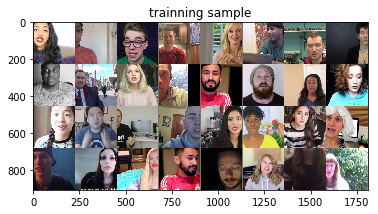

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='trainning sample')
plt.savefig('train_exp.png', bbox_inches='tight')

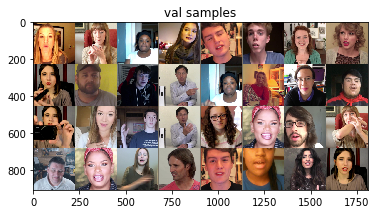

In [9]:
inputs2, classes2 = next(iter(dset_loaders['val']))
out2 = torchvision.utils.make_grid(inputs2)

imshow(out2, title='val samples')
plt.savefig('val_exp.png', bbox_inches='tight')

## Define Model

In [14]:
from our_nets import *

In [15]:
model_base = resnet50_noa_karen(verbose=True)

<bound method Module.modules of ResNet50_Noa_Karen (
  (resnet): ResNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): Bottleneck (
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## verify only the last fc layers params are being optimized

In [16]:
for l in model_base.parameters():
    if l.requires_grad == True:
        print (l)

Parameter containing:
1.00000e-02 *
-0.0612 -1.8212 -1.6410  ...  -0.5370  1.5530  1.0581
-1.6011  0.6007 -1.6246  ...   1.4115  1.1394 -0.4724
 1.2210  0.5281 -1.3190  ...   1.6125  1.6861  0.4223
 1.4488  1.0232  0.5912  ...  -1.2911 -0.8660 -2.0873
-1.2588 -1.4872  1.2647  ...   0.6533  2.0949 -0.8500
[torch.FloatTensor of size 5x2048]

Parameter containing:
1.00000e-02 *
 -1.7364
  1.0804
 -0.7517
  2.0926
 -0.5805
[torch.FloatTensor of size 5]



In [17]:
# some gpu configs
use_gpu = True
gpu_dtype = torch.cuda.FloatTensor

## Train The Model

### some helper functions

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/"%(exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/%s/'%(exp_name) + 'model_best.pth.tar')

def log_value(to_log, log_path = './log.txt'):
    log_file = open(log_path, 'a+')
    log_file.write(to_log)
    log_file.close()
    




## train and eval functions

In [19]:
log_freq = 50

def train(train_loader, model, criterion, optimizer, epoch) :
    batch_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, data in enumerate(train_loader):
        # measure data loading time
        input,target = data
        input_var, target_var = Variable(input.type(gpu_dtype)), Variable(target.type(gpu_dtype))
        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))
        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i % log_freq == 0:
            to_log = 'Epoch: [{0}][{1}/{2}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                   epoch, i, len(train_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            print(to_log)
            
       
    return losses.avg


def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, data in enumerate(val_loader):
        input,target = data
        input_var, target_var = Variable(input.type(gpu_dtype)), Variable(target.type(gpu_dtype))
        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i %  log_freq == 0:
            to_log = 'Val/Test: [{0}/{1}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            #print(to_log)
                        
    return losses.avg

## Train with Criterian (L2 loss) and Optimizer (Adam)

In [22]:
best_loss = 1000

# restart
model = copy.deepcopy(model_base).type(gpu_dtype)

# classic l2 loss
criterion = nn.MSELoss().type(gpu_dtype)

#only optimizing the new_fc layer parameters, other pretrained weights are freezed¶
optimizer  = optim.SGD(model.resnet.fc.parameters(),lr=1e-2, momentum=0.9)


# TODO: for larger dataset, consider a step function or exponentialdecay
def lr_scheduler(optimizer, epoch):
    return optimizer



for epoch in range(0,10):
    # train for one epoch
    train_loss = train(dset_loaders['train'], model, criterion, optimizer, epoch)

    # evaluate on validation set
    val_loss = validate(dset_loaders['val'], model, criterion, epoch)

    # log 
    log_value('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,train_loss=train_loss,val_loss=val_loss) ,'./epoch_log.txt')
    
    # remember best loss and save checkpoint
    is_best = val_loss <= best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'resnet50',
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    print (is_best, best_loss)

print ('Best Loss: ', best_loss)

Epoch: [0][0/709]	 Time 1.190 (1.190)	 Loss 0.026065 (0.026065)

Epoch: [0][50/709]	 Time 0.241 (0.260)	 Loss 0.030676 (0.024090)

Epoch: [0][100/709]	 Time 0.241 (0.250)	 Loss 0.015005 (0.021662)

Epoch: [0][150/709]	 Time 0.240 (0.247)	 Loss 0.013479 (0.020534)

Epoch: [0][200/709]	 Time 0.241 (0.246)	 Loss 0.019046 (0.019672)

Epoch: [0][250/709]	 Time 0.240 (0.245)	 Loss 0.011890 (0.018872)

Epoch: [0][300/709]	 Time 0.241 (0.244)	 Loss 0.015909 (0.018371)

Epoch: [0][350/709]	 Time 0.240 (0.244)	 Loss 0.011995 (0.017870)

Epoch: [0][400/709]	 Time 0.239 (0.244)	 Loss 0.016529 (0.017448)

Epoch: [0][450/709]	 Time 0.242 (0.244)	 Loss 0.011574 (0.017141)

Epoch: [0][500/709]	 Time 0.241 (0.243)	 Loss 0.014242 (0.016841)

Epoch: [0][550/709]	 Time 0.245 (0.243)	 Loss 0.014227 (0.016569)

Epoch: [0][600/709]	 Time 0.241 (0.243)	 Loss 0.012508 (0.016359)

Epoch: [0][650/709]	 Time 0.253 (0.243)	 Loss 0.016080 (0.016193)

Epoch: [0][700/709]	 Time 0.241 (0.243)	 Loss 0.011051 (0.015971)

In [25]:
for epoch in range(10,20):
    # train for one epoch
    train_loss = train(dset_loaders['train'], model, criterion, optimizer, epoch)

    # evaluate on validation set
    val_loss = validate(dset_loaders['val'], model, criterion, epoch)

    # log 
    log_value('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,train_loss=train_loss,val_loss=val_loss) ,'./epoch_log.txt')
    
    # remember best loss and save checkpoint
    is_best = val_loss <= best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'resnet50',
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    print (is_best,val_loss, best_loss)

print ('Best Loss: ', best_loss)

Epoch: [10][0/709]	 Time 1.224 (1.224)	 Loss 0.015608 (0.015608)

Epoch: [10][50/709]	 Time 0.240 (0.261)	 Loss 0.008597 (0.009375)

Epoch: [10][100/709]	 Time 0.239 (0.251)	 Loss 0.008937 (0.009151)

Epoch: [10][150/709]	 Time 0.244 (0.248)	 Loss 0.008401 (0.009280)

Epoch: [10][200/709]	 Time 0.242 (0.246)	 Loss 0.010488 (0.009301)

Epoch: [10][250/709]	 Time 0.246 (0.245)	 Loss 0.008107 (0.009197)

Epoch: [10][300/709]	 Time 0.240 (0.245)	 Loss 0.013551 (0.009238)

Epoch: [10][350/709]	 Time 0.243 (0.244)	 Loss 0.008413 (0.009215)

Epoch: [10][400/709]	 Time 0.240 (0.244)	 Loss 0.010154 (0.009189)

Epoch: [10][450/709]	 Time 0.239 (0.244)	 Loss 0.006997 (0.009185)

Epoch: [10][500/709]	 Time 0.243 (0.244)	 Loss 0.008891 (0.009210)

Epoch: [10][550/709]	 Time 0.241 (0.244)	 Loss 0.007111 (0.009188)

Epoch: [10][600/709]	 Time 0.242 (0.244)	 Loss 0.009720 (0.009166)

Epoch: [10][650/709]	 Time 0.242 (0.244)	 Loss 0.008783 (0.009140)

Epoch: [10][700/709]	 Time 0.241 (0.244)	 Loss 0.00

In [ ]:
for epoch in range(20,30):
    # train for one epoch
    train_loss = train(dset_loaders['train'], model, criterion, optimizer, epoch)

    # evaluate on validation set
    val_loss = validate(dset_loaders['val'], model, criterion, epoch)

    # log 
    log_value('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,train_loss=train_loss,val_loss=val_loss) ,'./epoch_log.txt')
    
    # remember best loss and save checkpoint
    is_best = val_loss <= best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'resnet50',
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    print (is_best,val_loss, best_loss)

print ('Best Loss: ', best_loss)


Epoch: [20][0/709]	 Time 1.158 (1.158)	 Loss 0.009468 (0.009468)

Epoch: [20][50/709]	 Time 0.241 (0.259)	 Loss 0.006534 (0.007867)

Epoch: [20][100/709]	 Time 0.241 (0.250)	 Loss 0.009798 (0.007903)

Epoch: [20][150/709]	 Time 0.241 (0.247)	 Loss 0.010616 (0.008023)

Epoch: [20][200/709]	 Time 0.241 (0.245)	 Loss 0.007458 (0.007955)

Epoch: [20][250/709]	 Time 0.238 (0.245)	 Loss 0.008010 (0.008016)

Epoch: [20][300/709]	 Time 0.239 (0.244)	 Loss 0.007551 (0.008003)

Epoch: [20][350/709]	 Time 0.243 (0.244)	 Loss 0.014460 (0.007975)

Epoch: [20][400/709]	 Time 0.241 (0.244)	 Loss 0.008485 (0.007996)

Epoch: [20][450/709]	 Time 0.242 (0.244)	 Loss 0.008211 (0.008008)

Epoch: [20][500/709]	 Time 0.243 (0.243)	 Loss 0.007066 (0.008015)

Epoch: [20][550/709]	 Time 0.241 (0.243)	 Loss 0.010346 (0.008058)

Epoch: [20][600/709]	 Time 0.242 (0.243)	 Loss 0.007761 (0.008080)

Epoch: [20][650/709]	 Time 0.244 (0.243)	 Loss 0.006293 (0.008081)

Epoch: [20][700/709]	 Time 0.241 (0.243)	 Loss 0.00

In [ ]:
'''
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_loss = 1000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
        
            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.type(gpu_dtype)), Variable(labels.type(gpu_dtype))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                # loss
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.data[0]

            epoch_loss = running_loss / dset_sizes[phase]

            print('{} Loss: {:f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:f}'.format(best_loss))
    return best_model

model = train_model(model, criterion, optimizer,
                         lr_scheduler, num_epochs=25)
                         


torch.save({
            'epoch': 25,
            'arch': 'resnet-tiny',
            'state_dict': model.state_dict(),
            'best_loss': 0.000005,
            'optimizer' : optimizer.state_dict(),
        },'0517checkpoint.tiny.tar')
                                        
'''

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, labels = next(iter(dset_loaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title='result')

inputs, labels = Variable(inputs.type(gpu_dtype)), Variable(labels.type(gpu_dtype))
outputs = model(inputs)
loss = criterion(outputs, labels)

for i in range(5):
    print('output',outputs.data[i,0],outputs.data[i,1],outputs.data[i,2],outputs.data[i,3],outputs.data[i,4])
    print('target',labels.data[i,0],labels.data[i,1],labels.data[i,2],labels.data[i,3],labels.data[i,4])
    print ('loss',loss.data[0])
    print (np.sqrt((labels.data[i]-output.data[i])**2))

    print ('---')




In [ ]:
accum_loss = 0
for i in range(32):
    print('output',outputs.data[i,0],outputs.data[i,1],outputs.data[i,2],outputs.data[i,3],outputs.data[i,4])
    print('target',labels.data[i,0],labels.data[i,1],labels.data[i,2],labels.data[i,3],labels.data[i,4])
    l=sum( ((labels.data[i]-outputs.data[i])**2) )
    #print (l  )
    accum_loss += l
    print ('---')
print ('their loss',loss.data[0])
print('my_loss',accum_loss/32)